# Apr 15th, 2022 (parcellation fix)

**Motivation**: Better gap filling (Delaunay + nearest neighbor max), and Render.  Now allowed num layers = [ 3, 2, 1] <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
_fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
set_style()

In [2]:
from register.atlas import Allen
from register.register import reset_ants_img
from register.parcellation import kmeans_parcellation, fill_img

In [3]:
mice = Mice((256, 2))

[PROGRESS] 'config.json' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-256*2

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

In [4]:
%%time

mice.parcel.fit_parcel(force_fit=True)

[PROGRESS] fit columnar: initiated

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

[PROGRESS] save 2D 10um: done

[PROGRESS] 2d --> 3d: done

[PROGRESS] save 3D 10um: done

[PROGRESS] downsample: done

num regions,    left: 512,  right: 512
region id diff,         r - l:  Counter({512: 512})

[PROGRESS] fit columnar: done

[PROGRESS] 'cols_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-256*2/parcellation

[PROGRESS] 'cortex_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-256*2/parcellation

[PROGRESS] 'cortex-top_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-256*2/parcellation

[PROGRESS] 'subcortex_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-256*2/parcellation

[PROGRESS] 'subcortex-l_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-256*2/parcellation

[PROGRESS] 'subcortex-r_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-256*2/parcellation

[PROGRESS] 'regions-top_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-256*2/parcellation

[PROGRESS] 'regions-cortex_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-256*2/parcellation

[PROGRESS] 'nonzero-idxs_parcel2d-flat_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-256*2/parcellation

[PROGRESS] 'nonzero-idxs_parcel2d-top_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-256*2/parcellation

[PROGRESS] 'nonzero-idxs_parcel3d_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-256*2/parcellation

[PROGRESS] 'region-idxs_parcel2d-flat_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-256*2/parcellation

[PROGRESS] 'region-idxs_parcel2d-top_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-256*2/parcellation

[PROGRESS] 'region-idxs_parcel3d_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-256*2/parcellation

[PROGRESS] 'shape_parcel2d-flat_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-256*2/parcellation

[PROGRESS] 'shape_parcel2d-top_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-256*2/parcellation

[PROGRESS] 'shape_parcel3d_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-256*2/parcellation

[PROGRESS] save results: done.

CPU times: user 3h 11min 57s, sys: 19min 29s, total: 3h 31min 26s
Wall time: 16min 54s


In [5]:
iso_mask = mice.al.get_masks('Isocortex')

<matplotlib.image.AxesImage object at 0x7f54ad0007f0>

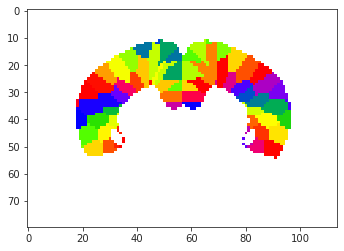

In [6]:
plt.imshow(mwh(iso_mask[40] == 0, mice.parcel['cols'][40]), cmap='prism')

<matplotlib.image.AxesImage object at 0x7f544bf6fb80>

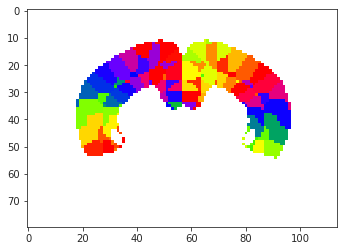

In [7]:
plt.imshow(mwh(iso_mask[40] == 0, mice.parcel['cortex'][40]), cmap='prism')

<matplotlib.image.AxesImage object at 0x7f544c31f580>

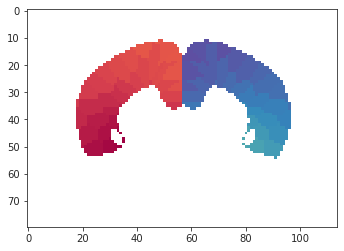

In [8]:
plt.imshow(mwh(iso_mask[40] == 0, mice.parcel['cols'][40]), cmap='Spectral')

<matplotlib.image.AxesImage object at 0x7f54512cc5e0>

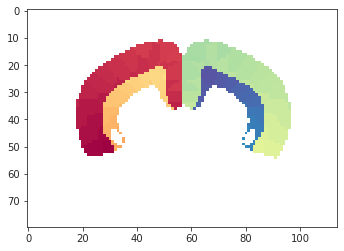

In [23]:
plt.imshow(mwh(iso_mask[40] == 0, mice.parcel['cortex'][40]), cmap='Spectral')

<matplotlib.image.AxesImage object at 0x7f5433223a00>

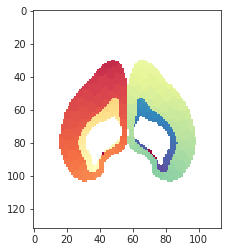

In [25]:
plt.imshow(mwh(iso_mask[:, 15] == 0, mice.parcel['cortex'][:, 15]), cmap='Spectral')

In [9]:
iso_mask = mice.al.get_masks('Isocortex')
x = dc(mice.parcel['cols']).astype(float)
x[~iso_mask] = np.nan

<matplotlib.image.AxesImage object at 0x7f54ad07d640>

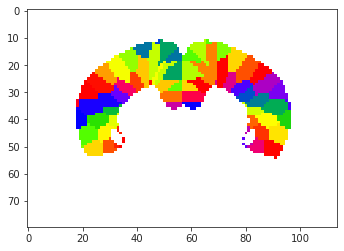

In [10]:
plt.imshow(x[40], cmap='prism')

<matplotlib.image.AxesImage object at 0x7f544c338760>

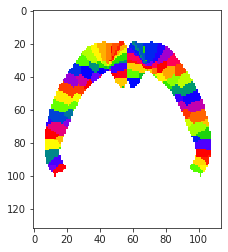

In [11]:
plt.imshow(x[:, 30], cmap='prism')

In [114]:
points = np.where(np.logical_and(iso_mask, mice.parcel['cortex'] == 0))
points = list(zip(*points))
for i, j, k in tqdm(points):
    nn = list(itertools.product(*[
        [x + d for d in [-1, 0, 1]]
        for x in [i, j, k]
    ]))
    nn = [e for e in nn if e != (i, j, k)]
    # nn.pop(nn.index((i, j, k)))
    vals = x[list(zip(*nn))]
    vals = vals[~np.isnan(vals)]
    if not len(vals):
        continue
    vals = collections.Counter(vals).most_common()
    for r, _ in vals:
        if r > 0:
            x[i, j, k] = r
            break
    if r == 0:
        print(vals)

  0%|          | 0/5335 [00:00<?, ?it/s]

[(0.0, 1)]

[(0.0, 1)]

[(0.0, 1)]

In [115]:
for i, j, k in tqdm(points):
    nn = list(itertools.product(*[
        [x + d for d in [-1, 0, 1]]
        for x in [i, j, k]
    ]))
    nn.pop(nn.index((i, j, k)))
    vals = x[list(zip(*nn))]
    vals = vals[~np.isnan(vals)]
    if not len(vals):
        continue
    vals = collections.Counter(vals).most_common()
    for r, _ in vals:
        if r > 0:
            x[i, j, k] = r
            break
    if r == 0:
        print(vals)

  0%|          | 0/5335 [00:00<?, ?it/s]

[(0.0, 1)]

[(0.0, 1)]

<matplotlib.image.AxesImage object at 0x7fcbf29f1520>

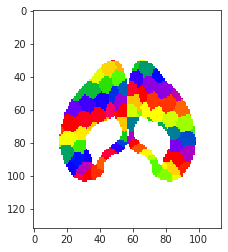

In [116]:
plt.imshow(x[:, 15], cmap='prism')

<matplotlib.image.AxesImage object at 0x7fcbf29baf70>

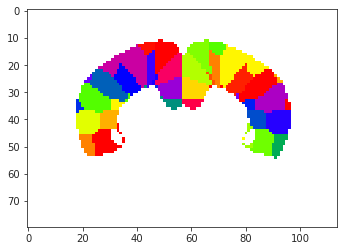

In [117]:
plt.imshow(x[40], cmap='prism')

<matplotlib.image.AxesImage object at 0x7fcbf291b700>

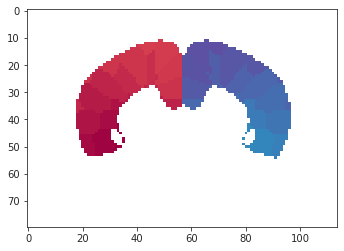

In [118]:
plt.imshow(x[40], cmap='Spectral')

In [102]:
vals

[(502.0, 5), (498.0, 4)]

In [4]:
al10 = Allen(
    resolution=10,
    proj_mode='dorsal_flatmap',
    full_load=True,
)

<matplotlib.image.AxesImage object at 0x7f4a792fea90>

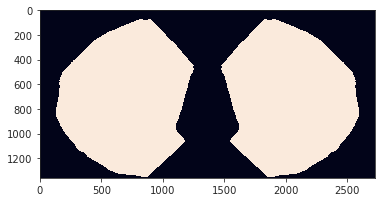

In [5]:
x = al10.lookup > 0
plt.imshow(x)

In [6]:
%%time

output = kmeans_parcellation(
    mask=al10.lookup > 0,
    n_hemisphere_regions=mice.cfg.nn,
    n_layers=mice.cfg.ll,
    random_state=mice.cfg.random_state,
    radius=mice.parcel.radius,
    lr_axis=1,
)

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


CPU times: user 1h 50min 21s, sys: 8min 15s, total: 1h 58min 36s
Wall time: 4min 39s


<matplotlib.image.AxesImage object at 0x7f4a625b6b20>

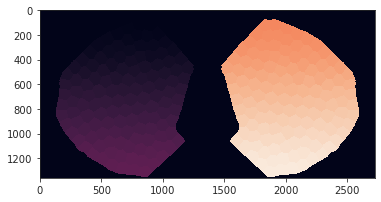

In [7]:
parcel2d = output['parcel']
plt.imshow(parcel2d)

In [8]:
regions = parcel2d[parcel2d.nonzero()]
regions = np.unique(regions)
parcel3d = np.zeros_like(al10.template)

In [9]:
for i in regions:
    idxs = np.where(parcel2d == i)
    for item in al10.lookup[idxs]:
        path = al10.paths[item]
        path = path[path.nonzero()]
        parcel3d.flat[path] = i

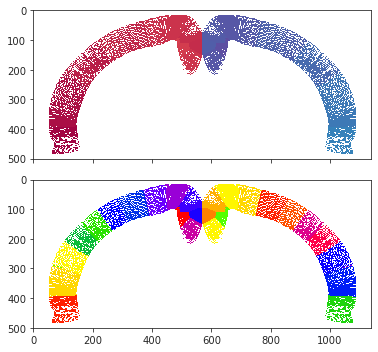

In [10]:
fig, axes = create_figure(2, 1, (6, 5), 'all', 'all')
axes[0].imshow(mwh(parcel3d[800] == 0, parcel3d[800]), cmap='Spectral')
axes[1].imshow(mwh(parcel3d[800] == 0, parcel3d[800]), cmap='prism')
axes[0].set_ylim(500, 0)
plt.show()

In [11]:
parcel3d = reset_ants_img(parcel3d, 10)

In [12]:
%%time

if hasattr(mice.al, 'template'):
    tgt = mice.al.template
else:
    tgt, _ = mice.al.mcc.get_template_volume()
tgt = reset_ants_img(
    img=tgt.astype('uint32'),
    spacing=mice.al.mcc.resolution,
)
parcel3d_down = ants.resample_image_to_target(
    image=parcel3d, target=tgt,
    interp_type='genericLabel',
)
cortex = parcel3d_down.numpy().astype('uint32')

CPU times: user 1min 4s, sys: 18.5 s, total: 1min 23s
Wall time: 45.6 s


<matplotlib.image.AxesImage object at 0x7f4a602a6ac0>

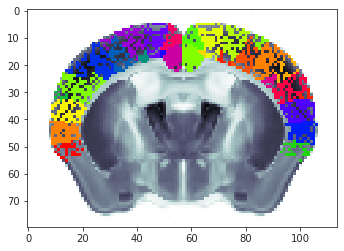

In [13]:
plt.imshow(tgt[60], cmap='bone_r')
plt.imshow(mwh(cortex[60] == 0, cortex[60]), cmap='prism')

<matplotlib.image.AxesImage object at 0x7f4a6251cb20>

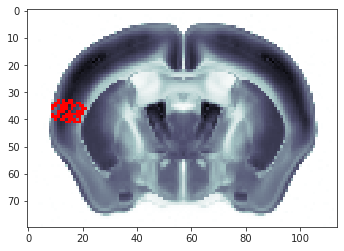

In [14]:
plt.imshow(tgt[60], cmap='bone_r')
plt.imshow(mwh(cortex[60] != 52, cortex[60]), cmap='prism')

<matplotlib.image.AxesImage object at 0x7f4a6258fcd0>

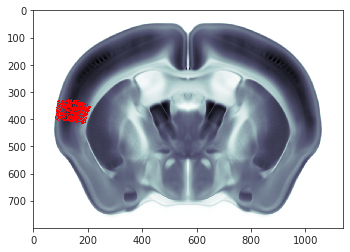

In [15]:
plt.imshow(al10.template[600], cmap='bone_r')
plt.imshow(mwh(parcel3d[600] != 52, parcel3d[600]), cmap='prism')

In [44]:
def _fill_gaps(x: np.ndarray, valid_mask: np.ndarray = None):
    if valid_mask is None:
        valid_mask = np.ones(x.shape)
    pts_valid = np.array(list(zip(*np.where(valid_mask))))
    regions = x[x.nonzero()]
    regions = np.unique(regions)
    x_fill = np.zeros_like(x)
    for r in tqdm(regions):
        pts = list(zip(*np.where(x == r)))
        tri = sp_spat.Delaunay(pts)
        vol = tri.find_simplex(pts_valid) >=0
        x_fill[list(zip(*pts_valid[vol]))] = r
    return x_fill

In [45]:
x_fill = _fill_gaps(cortex, iso_mask)

  0%|          | 0/256 [00:00<?, ?it/s]

<matplotlib.image.AxesImage object at 0x7f4ad880ec40>

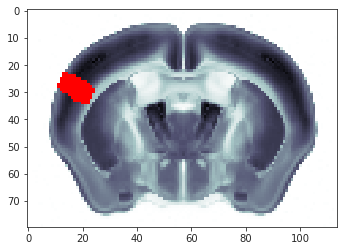

In [55]:
plt.imshow(tgt[60], cmap='bone_r')
plt.imshow(mwh(x_fill[60] != 58, x_fill[60]), cmap='prism')

<matplotlib.image.AxesImage object at 0x7f4ad89acc70>

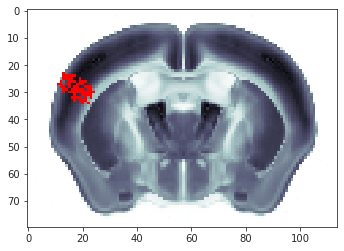

In [57]:
plt.imshow(tgt[60], cmap='bone_r')
plt.imshow(mwh(cortex[60] != 58, cortex[60]), cmap='prism')

<matplotlib.image.AxesImage object at 0x7f4ad6809910>

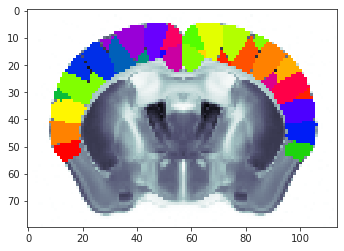

In [91]:
plt.imshow(tgt[60], cmap='bone_r')
plt.imshow(mwh(x_fill[60] == 0, x_fill[60]), cmap='prism')

<matplotlib.image.AxesImage object at 0x7f4ad6486fa0>

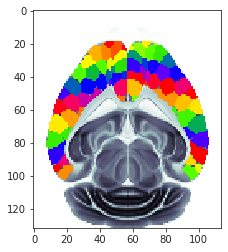

In [101]:
i = 25
plt.imshow(tgt[:, i], cmap='bone_r')
plt.imshow(mwh(x_fill[:, i] == 0, x_fill[:, i]), cmap='prism')

In [71]:
len(np.unique(x_fill[65])) - 1

38

<matplotlib.image.AxesImage object at 0x7f4ad67e1a90>

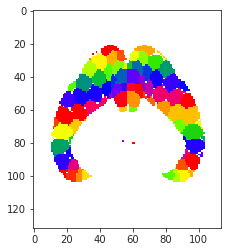

In [90]:
plt.imshow(mwh(x_fill[:, 21] == 0, x_fill[:, 21]), cmap='prism')

In [118]:
def _fill_gaps(x: np.ndarray, valid_mask: np.ndarray = None):
    if valid_mask is None:
        valid_mask = np.ones(x.shape)
    pts_valid = np.array(list(zip(*np.where(valid_mask))))
    regions = x[x.nonzero()]
    regions = np.unique(regions)
    x_fill = np.zeros_like(x)
    for r in tqdm(regions):
        pts = list(zip(*np.where(x == r)))
        try:
            tri = sp_spat.Delaunay(pts)
        except sp_spat.qhull.QhullError:
            continue
        vol = tri.find_simplex(pts_valid) > -1
        x_fill[list(zip(*pts_valid[vol]))] = r
    return x_fill

In [119]:
x2d = _fill_gaps(top2d)

  0%|          | 0/200 [00:00<?, ?it/s]

<matplotlib.image.AxesImage object at 0x7f4ab20dc730>

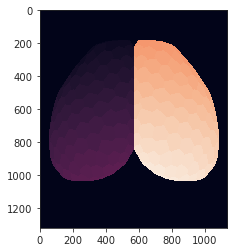

In [120]:
plt.imshow(x2d)

<matplotlib.image.AxesImage object at 0x7f4ad6b02cd0>

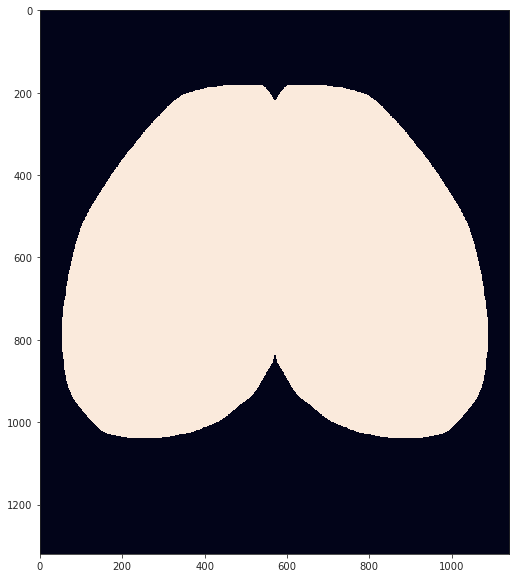

In [121]:
plt.figure(figsize=(15, 10))
plt.imshow(x2d > 0)

<matplotlib.image.AxesImage object at 0x7f4ad8c7eaf0>

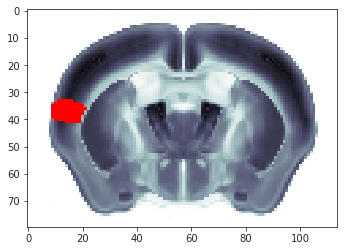

In [58]:
plt.imshow(tgt[60], cmap='bone_r')
plt.imshow(mwh(x[60] != 52, x[60]), cmap='prism')

In [123]:
ll = 3
num = mice.cfg.nn
num *= ll * 2
# if self.cfg.ll == 0:
expected = list(range(1, mice.cfg.nn + 1))
expected += list(range(num//2 + 1, num//2 + mice.cfg.nn + 1))
# else:
  #   expected = range(1, num + 1)

In [125]:
len(expected)

256

In [126]:
len(regions)

256

In [127]:
num = mice.cfg.nn
num *= mice.cfg.ll * 2

In [128]:
num

768

In [129]:
128 * 3 * 2

768

In [16]:
points = list(zip(*np.where(cortex == 52)))
tri = sp_spat.Delaunay(points)

In [17]:
iso_mask = mice.al.get_masks('Isocortex')
iso_pts = np.array(list(zip(*np.where(iso_mask))))

In [18]:
%%time

vol = tri.find_simplex(iso_pts) >=0

CPU times: user 24.4 ms, sys: 0 ns, total: 24.4 ms
Wall time: 22.5 ms


In [19]:
x = np.zeros(iso_mask.shape)
x[list(zip(*iso_pts[vol]))] = 52

<matplotlib.image.AxesImage object at 0x7f4a6241b880>

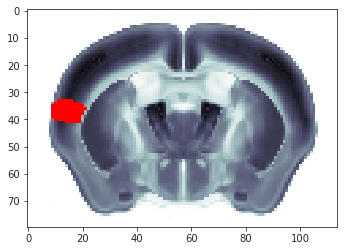

In [20]:
plt.imshow(tgt[60], cmap='bone_r')
plt.imshow(mwh(x[60] != 52, x[60]), cmap='prism')

<matplotlib.image.AxesImage object at 0x7f4a7926e700>

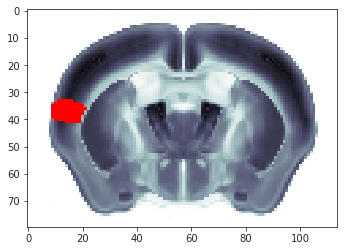

In [21]:
i = 60
plt.imshow(tgt[i], cmap='bone_r')
plt.imshow(mwh(x[i] != 52, x[i]), cmap='prism')

<matplotlib.image.AxesImage object at 0x7f4a6240cbe0>

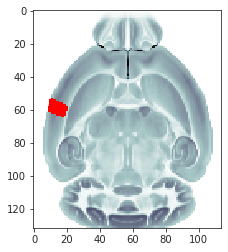

In [31]:
i = 38
plt.imshow(tgt[:, i], cmap='bone_r')
plt.imshow(mwh(x[:, i] != 52, x[:, i]), cmap='prism')

<matplotlib.image.AxesImage object at 0x7f4a6201ad60>

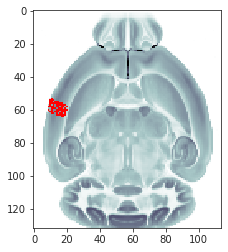

In [32]:
i = 38
plt.imshow(tgt[:, i], cmap='bone_r')
plt.imshow(mwh(cortex[:, i] != 52, cortex[:, i]), cmap='prism')

In [33]:
top2d = al10.cortical_map(
    volume=parcel3d.numpy(),
    proj_mode='top_view',
    agg_func=np.max,
)

<matplotlib.image.AxesImage object at 0x7f4ada3a1eb0>

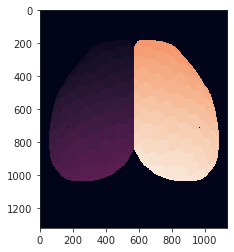

In [34]:
plt.imshow(top2d)

## Render

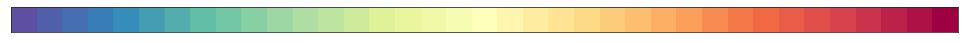

In [12]:
sys.path.insert(0, pjoin(git_dir, 'vedo'))
sys.path.insert(0, pjoin(git_dir, 'brainrender'))

from bg_space import AnatomicalSpace

from brainrender import Scene
from brainrender import settings as br_settings
from brainrender.actors.streamlines import make_streamlines
from brainrender.atlas_specific import get_streamlines_for_region

from vedo import Volume as vd_Volume
from register.atlas import load_bg_atlas

cmap = sns.color_palette('Spectral_r', as_cmap=True)
display_cmap(cmap)

### Columns

In [13]:
regions = mice.parcel['cols'][mice.parcel['cols'].nonzero()]
regions = np.unique(regions)
len(regions)

512

In [15]:
alpha_root = 0.2

_root_alpha = br_settings.ROOT_ALPHA
br_settings.ROOT_ALPHA = alpha_root
br_settings.RENDER = False

scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)

In [16]:
surfaces, names, colors = [], [], []
for i, region_id in tqdm(enumerate(regions), total=len(regions)):
    x = mice.parcel['cols'] == region_id
    x = src_space.map_stack_to(scene.atlas.space, x)
    c = cmap(i / len(regions))[:3]
    colors.append(c)

    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(1.0).lw(0).c(rgb2hex(c))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"region_{region_id}")
    
scene.add_silhouette(*scene.actors, lw=0.7, color='k')
scene.add(*surfaces, names=names, colors=colors)

html_file = [
    f"k{len(regions)}",
]
html_file = pjoin(tmp_dir, f'COLS-{mice.cfg.nn}.html')

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

  0%|          | 0/512 [00:00<?, ?it/s]

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/COLS-256.html

### Cortex

In [17]:
regions = mice.parcel['cortex'][mice.parcel['cortex'].nonzero()]
regions = np.unique(regions)
len(regions)

1024

In [18]:
alpha_root = 0.2

_root_alpha = br_settings.ROOT_ALPHA
br_settings.ROOT_ALPHA = alpha_root
br_settings.RENDER = False

scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)

In [19]:
surfaces, names, colors = [], [], []
for i, region_id in tqdm(enumerate(regions), total=len(regions)):
    x = mice.parcel['cortex'] == region_id
    x = src_space.map_stack_to(scene.atlas.space, x)
    c = cmap(i / len(regions))[:3]
    colors.append(c)

    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(1.0).lw(0).c(rgb2hex(c))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"region_{region_id}")
    
scene.add_silhouette(*scene.actors, lw=0.7, color='k')
scene.add(*surfaces, names=names, colors=colors)

html_file = [
    f"k{len(regions)}",
]
html_file = pjoin(tmp_dir, f'CORTEX-{mice.cfg.nn}.html')

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

  0%|          | 0/1024 [00:00<?, ?it/s]

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/CORTEX-256.html